<a href="https://colab.research.google.com/github/Rhymster16/hello/blob/main/p333.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imbalanced-learn
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder # Import OrdinalEncoder here
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb


In [2]:
data = pd.read_csv('/content/hospital_readmissions.csv')

In [3]:
data.fillna(method='ffill', inplace=True)

<ipython-input-3-519281724d28>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [11]:
categorical_features = ['medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'diabetes_med']
numerical_features = ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications',
                      'n_outpatient', 'n_inpatient', 'n_emergency']
object_features = X.select_dtypes(include='object').columns.tolist()

In [5]:
data['readmitted'] = data['readmitted'].apply(lambda x: 1 if x == 'yes' else 0)

In [6]:
def age_to_numeric(age_str):
    """Converts age range string to a representative numeric value."""
    if age_str == '[0-10)':
        return 5
    elif age_str == '[10-20)':
        return 15
    elif age_str == '[20-30)':
        return 25
    elif age_str == '[30-40)':
        return 35
    elif age_str == '[40-50)':
        return 45
    elif age_str == '[50-60)':
        return 55
    elif age_str == '[60-70)':
        return 65
    elif age_str == '[70-80)':
        return 75
    elif age_str == '[80-90)':
        return 85
    elif age_str == '[90-100)':
        return 95
    else:
        return float('nan')  # Handle unexpected values

data['age'] = data['age'].apply(age_to_numeric)

In [10]:
object_features = X_train.select_dtypes(include='object').columns.tolist()

In [7]:
for feature in categorical_features:
    if feature not in data.columns:
        print(f"Warning: '{feature}'  not found in DataFrame columns.")

In [8]:
X = data.drop('readmitted', axis=1)
y = data['readmitted']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
from sklearn.impute import SimpleImputer
# Impute missing values using SimpleImputer
# Create different imputers for numerical and categorical features
num_imputer = SimpleImputer(strategy='mean')  # Use mean for numerical features
cat_imputer = SimpleImputer(strategy='most_frequent')  # Use most frequent for categorical features

# Apply imputers to the respective features
X_train[numerical_features] = num_imputer.fit_transform(X_train[numerical_features])

# Replace pd.NA with NaN before applying SimpleImputer to object features
X_train[object_features] = X_train[object_features].fillna(np.nan)
X_train[object_features] = cat_imputer.fit_transform(X_train[object_features])

X_test[numerical_features] = num_imputer.transform(X_test[numerical_features])
# Replace pd.NA with NaN before applying SimpleImputer to object features
X_test[object_features] = X_test[object_features].fillna(np.nan)
X_test[object_features] = cat_imputer.transform(X_test[object_features])

# Convert object columns to string type to ensure uniformity
X_train[object_features] = X_train[object_features].astype(str)
X_test[object_features] = X_test[object_features].astype(str)


In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')), # Impute missing numerical values
            ('scaler', StandardScaler())  # Apply StandardScaler after imputation
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # Apply OneHotEncoder after imputation
        ]), object_features),  # Using object_features here
        ('age_ord', OrdinalEncoder(), ['age'])
    ])

In [25]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

In [26]:
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(object_features)
age_feature_name = preprocessor.named_transformers_['age_ord'].get_feature_names_out(['age'])
all_feature_names = numerical_features + list(onehot_feature_names) + list(age_feature_name)



In [27]:
pipeline = Pipeline(steps=[
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

In [28]:
param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [5, 7, 9],
    'classifier__learning_rate': [0.05, 0.1, 0.15],
    'classifier__subsample': [0.8, 1.0]
}


In [29]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:02:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:02:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:02:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:02:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:02:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_typ...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.05, 0.1, 0.15],
                         'classifier__max_depth': [5, 7, 9],
                         'classifier__n_estimators': [200, 300],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='accuracy')

In [30]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(preprocessor.transform(X_test))

In [31]:
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Parameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Accuracy: 0.6142
              precision    recall  f1-score   support

           0       0.62      0.70      0.66      2658
           1       0.60      0.51      0.55      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000



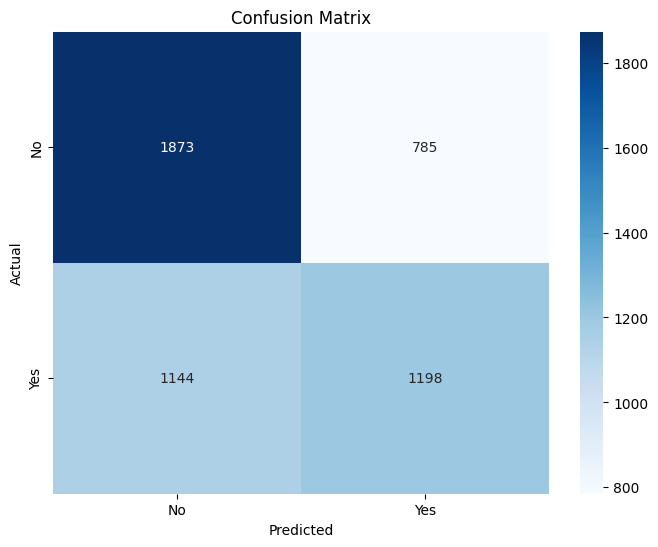

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
classifier = best_model.named_steps['classifier']
feature_importances = classifier.feature_importances_


In [36]:
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(object_features)
# Get feature name for age from the preprocessor
age_feature_name = preprocessor.named_transformers_['age_ord'].get_feature_names_out(['age'])
# Combine all feature names
all_feature_names = numerical_features + list(onehot_feature_names) + list(age_feature_name)


In [38]:
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(object_features)
# Get feature name for age from the preprocessor
age_feature_name = preprocessor.named_transformers_['age_ord'].get_feature_names_out(['age'])
# Combine all feature names
all_feature_names = numerical_features + list(onehot_feature_names) + list(age_feature_name)


<ipython-input-40-31a314fe5713>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


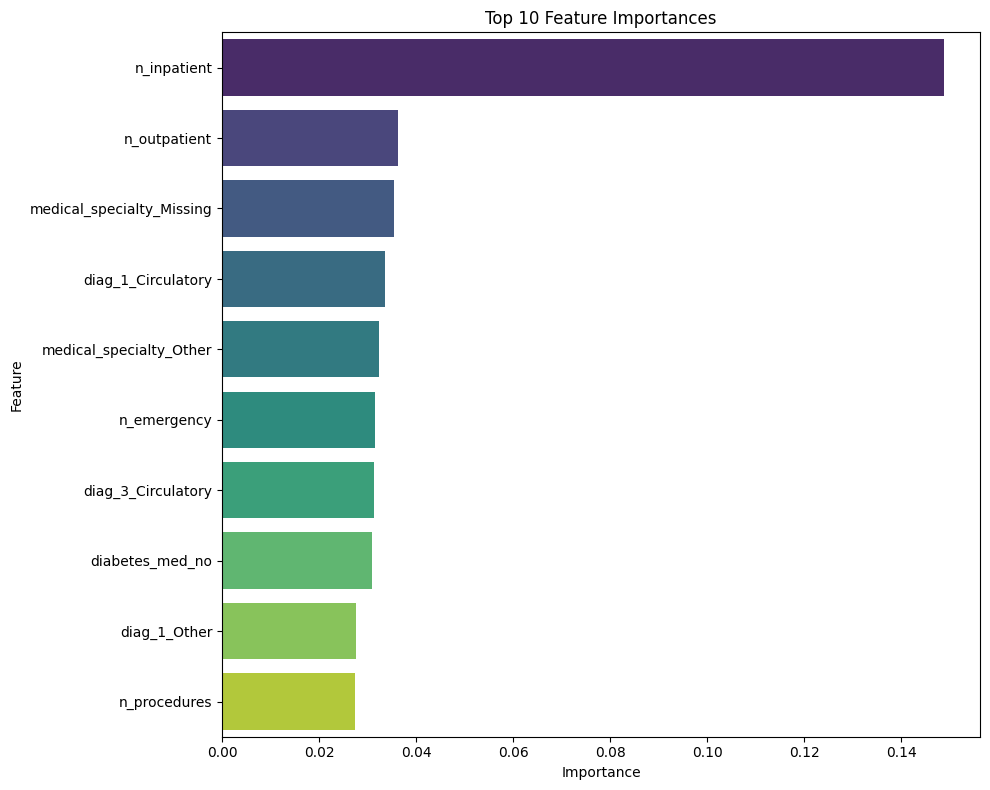

In [40]:
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
